<a href="https://colab.research.google.com/github/ZotovDmitry/KaggleLogisticRegressor/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

My team name on kaggle - DmitryZotov

My kaggle score is 0.85252

# First. Data research

In [ ]:
import pandas as pd
import numpy as np
import catboost
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
!pip install catboost

In [ ]:
#Loading Data
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
!kaggle competitions download -c advanced-dls-spring-2021

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
submission.csv: Skipping, found more recently modified local copy (use --force to force download)


## Downloading Data


In [ ]:
#downloading test.csv
data = pd.read_csv('train.csv')

In [ ]:
data.head() #looking on the first rows

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [ ]:
data.info() 
# TotalSent isn't numeric - it needs to be changed to float
# There is no null in the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [ ]:
#numeric columns
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

#categorial columns
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
numeric_data = data[num_cols]
categorial_data = data[cat_cols]
y = data[target_col] #making label set

In [ ]:
numeric_data.head() #we can see that TotalSpent roughly equals to the multiplying ClientPeriod and MonthlySpending
#we can use this fact in future

,ClientPeriod,MonthlySpending,TotalSpent
0,55,19.50,1026.35
1,72,25.85,1872.2
2,1,75.90,75.9
3,32,79.30,2570
4,60,115.25,6758.45


In [ ]:
for index, item in enumerate(data.loc[:,'TotalSpent']):
  try:
    if type(item) == str:
      data.loc[index,'TotalSpent'] = float(data.loc[index,'TotalSpent'])
  except ValueError: #As said before, TotalSpent roughly equals to multiplying ClientPeriod and MonthlySpending
    data.loc[index,'TotalSpent'] = data.loc[index,'MonthlySpending'] * data.loc[index,'ClientPeriod']
    continue
data.loc[:,'TotalSpent'] = pd.to_numeric(data.loc[:,'TotalSpent'])

In [ ]:
data.info() #now TotalSpent's type is float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

## Data Analysis

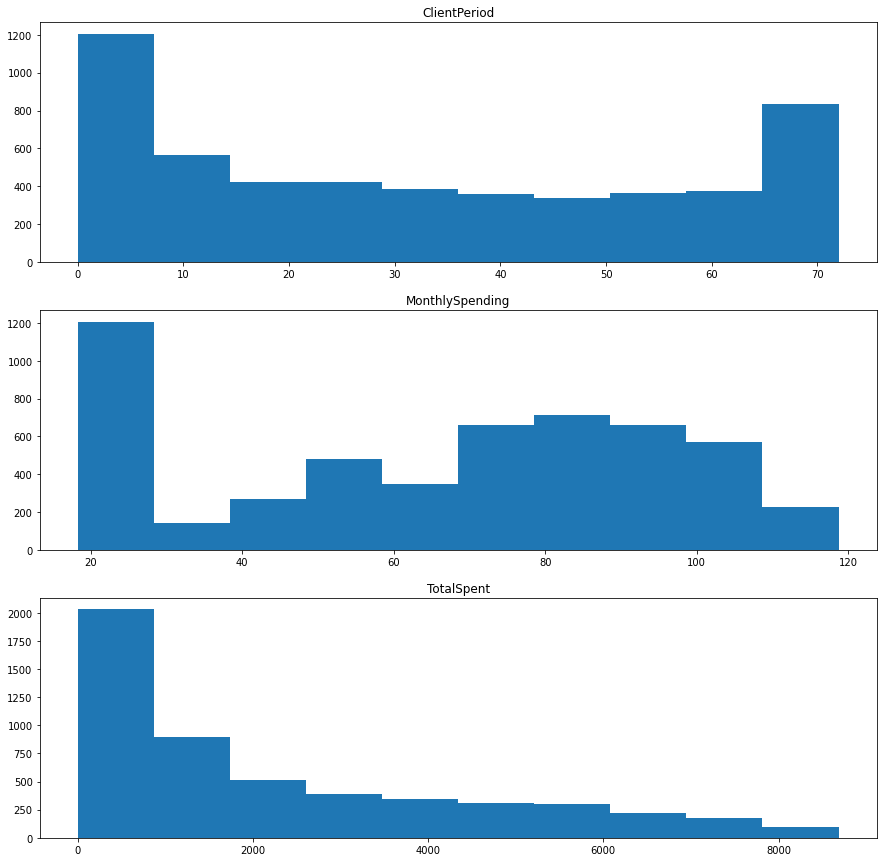

In [ ]:
# in the plots we can see that our numeric data is unbalanced 
# TotalSpent values is many times bigger than others
# so we need to normilize numeric data
plt.figure(figsize=(15,15))
for id, item in enumerate(num_cols):
  plt.subplot(len(num_cols), 1, id+1)
  plt.hist(data[item])
  plt.title(item)

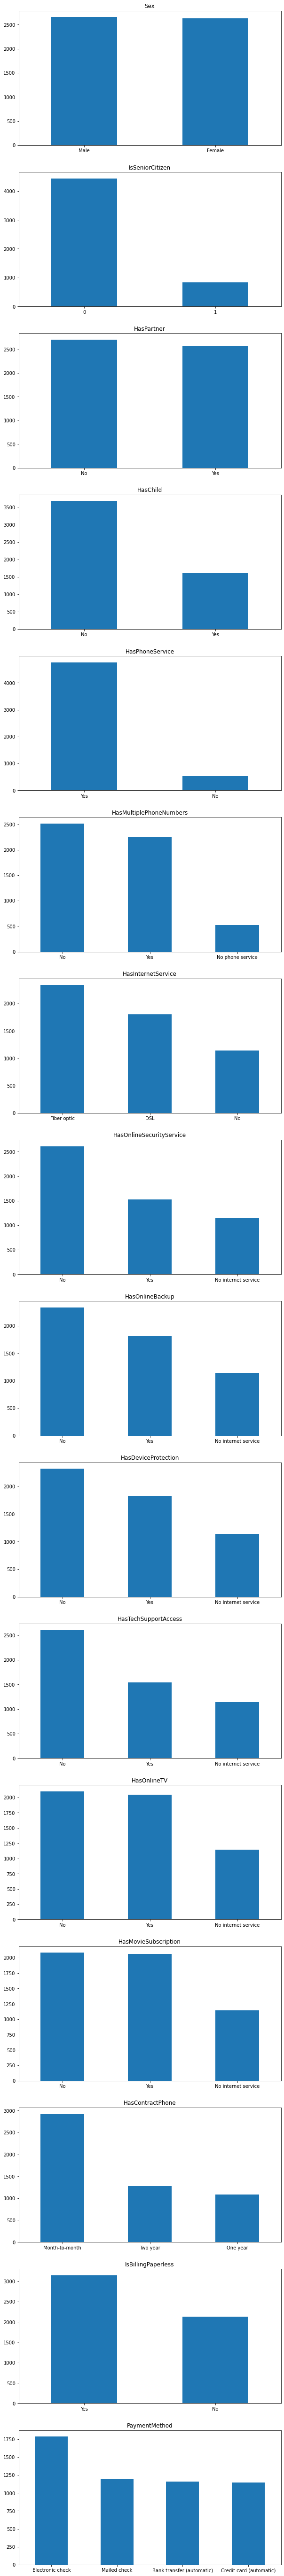

In [ ]:
#making bar-plots of categorical data
plt.figure(figsize=(10,100))
for id, item in enumerate(cat_cols):
  plt.subplot(len(cat_cols), 1, id+1)
  data[item].value_counts().plot(kind='bar')
  plt.xticks(rotation=0)
  plt.title(item)

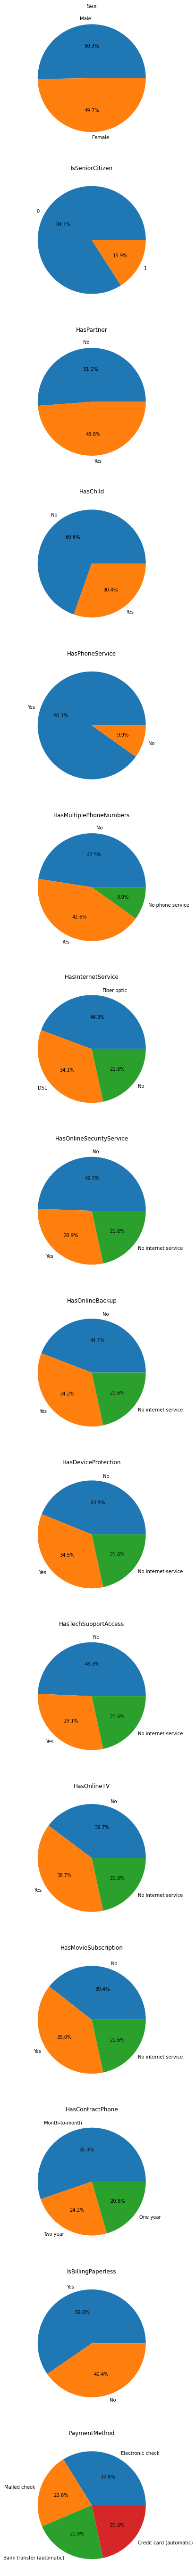

In [ ]:
#making pie-plots of categorical data
plt.figure(figsize=(100,100))
for id, item in enumerate(cat_cols):
  plt.subplot(len(cat_cols), 1, id+1)
  data[item].value_counts().plot(kind='pie', autopct='%1.1f%%', ylabel='' )
  plt.title(item)

In [ ]:
numeric_data = data[num_cols]
categorial_data = data[cat_cols]

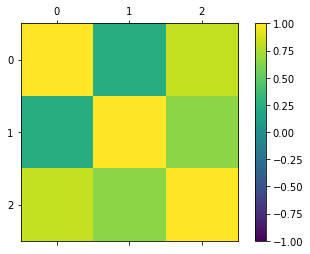

In [ ]:
# looking for some high correlation between numeric features
correlations = numeric_data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [ ]:
#we can see that there is high correlation beetween TotalSpent and two other features
correlations 

,ClientPeriod,MonthlySpending,TotalSpent
ClientPeriod,1.000000,0.249414,0.826658
MonthlySpending,0.249414,1.000000,0.652014
TotalSpent,0.826658,0.652014,1.000000


In [ ]:
#We should remove the least informative column that is highly correlated with other feature
#As said before, TotalSpent roughly equals to multiplying ClientPeriod and MonthlySpending
#We do it just for making linear independence of feature matrix
numeric_data = numeric_data.loc[:,:].drop('ClientPeriod', axis=1)

## Applying of Linear Models


In [ ]:
#One-Hot encoding categorical features
dummy_features = pd.get_dummies(categorial_data)
dummy_features

,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,HasMultiplePhoneNumbers_No,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_DSL,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No,HasOnlineSecurityService_No internet service,HasOnlineSecurityService_Yes,HasOnlineBackup_No,HasOnlineBackup_No internet service,HasOnlineBackup_Yes,HasDeviceProtection_No,HasDeviceProtection_No internet service,HasDeviceProtection_Yes,HasTechSupportAccess_No,HasTechSupportAccess_No internet service,HasTechSupportAccess_Yes,HasOnlineTV_No,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1
1,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0
2,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3,1,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
4,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
5278,0,0,1,0,1,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0
5279,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
5280,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0


In [ ]:
#normilising numeric data
scaler = StandardScaler()
scaler.fit(numeric_data)
scaler.transform(numeric_data)
numeric_data = pd.DataFrame(scaler.transform(numeric_data), index=numeric_data.index, columns=numeric_data.columns)

In [ ]:
#making feature dataframe 
X = pd.concat([numeric_data, dummy_features], axis=1)
X.head()

,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,HasMultiplePhoneNumbers_No,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_DSL,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No,HasOnlineSecurityService_No internet service,HasOnlineSecurityService_Yes,HasOnlineBackup_No,HasOnlineBackup_No internet service,HasOnlineBackup_Yes,HasDeviceProtection_No,HasDeviceProtection_No internet service,HasDeviceProtection_Yes,HasTechSupportAccess_No,HasTechSupportAccess_No internet service,HasTechSupportAccess_Yes,HasOnlineTV_No,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.505447,-0.555852,0,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1
1,-1.294998,-0.183039,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0
2,0.363737,-0.974768,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3,0.476418,0.124519,1,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
4,1.667856,1.970599,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0


In [ ]:
#making unprocessed data for Yandex Boosting
X_origin = data.iloc[:, :-1]

In [ ]:
#for the same reason as for processed data we drop first column (ClientPeriod)
X_origin.drop('ClientPeriod', axis=1, inplace=True)

In [ ]:
#looking on the origin feature dataframe
X_origin.head()

,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)


In [ ]:
#making and fitting logistic regression, founding out its best parameters
grid={"C":np.array([0.001,0.01,0.1,1,10,100])}# l2 ridge penalty
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
#Best Params of our logreg are
logreg_cv.best_params_

{'C': 1.0}

In [ ]:
#quality of model equals to

train_auc = roc_auc_score(y, logreg_cv.predict(X))
train_auc

0.7151242151748192

## Applying of gradient boosting


In [ ]:
#setting categorical_indices
categorical_indices = np.array([2, 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
categorical_indices = categorical_indices.astype(int)
categorical_indices

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
# CatBoost works with categorial values by itself
# Splitting our data to train and test
X_train_origin, X_test_origin, y_train, y_test = train_test_split(X_origin.values, y.values, 
                                                       train_size=0.8, 
                                                       random_state=42)

In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
                                             cat_features=categorical_indices)

boosting_model.fit(X_train_origin, y_train)

y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

Learning rate set to 0.083391
0:	learn: 0.6365776	total: 66.2ms	remaining: 13.2s
1:	learn: 0.5948864	total: 79.4ms	remaining: 7.86s
2:	learn: 0.5626496	total: 92.3ms	remaining: 6.06s
3:	learn: 0.5374136	total: 103ms	remaining: 5.07s
4:	learn: 0.5140575	total: 116ms	remaining: 4.54s
5:	learn: 0.4980680	total: 125ms	remaining: 4.04s
6:	learn: 0.4823225	total: 140ms	remaining: 3.85s
7:	learn: 0.4696942	total: 155ms	remaining: 3.72s
8:	learn: 0.4600478	total: 169ms	remaining: 3.58s
9:	learn: 0.4515672	total: 182ms	remaining: 3.46s
10:	learn: 0.4444722	total: 201ms	remaining: 3.45s
11:	learn: 0.4387954	total: 216ms	remaining: 3.38s
12:	learn: 0.4323270	total: 237ms	remaining: 3.42s
13:	learn: 0.4271567	total: 253ms	remaining: 3.36s
14:	learn: 0.4230027	total: 269ms	remaining: 3.31s
15:	learn: 0.4207526	total: 281ms	remaining: 3.23s
16:	learn: 0.4179618	total: 297ms	remaining: 3.19s
17:	learn: 0.4155841	total: 310ms	remaining: 3.14s
18:	learn: 0.4132550	total: 331ms	remaining: 3.15s
19:	lear

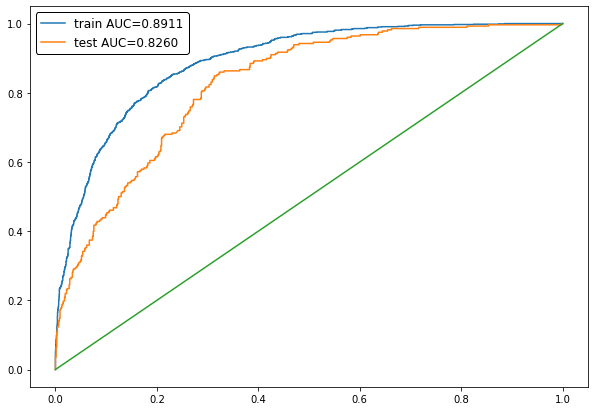

In [ ]:
#making ROC-AUC score of gradient boosting model
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

# Predictions

In [ ]:
#best model is boosting model
best_model = boosting_model

In [ ]:
#download test data and submission-file
X_test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [ ]:
#looking on the test data first rows
X_test.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


In [ ]:
# TotalSent isn't numeric - it needs to be changed to float
# There is no null in the dataframe
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [ ]:
#changing type of numeric column (from str to float)
for index, item in enumerate(X_test.loc[:,'TotalSpent']):
  try:
    if type(item) == str:
      X_test.loc[index,'TotalSpent'] = float(X_test.loc[index,'TotalSpent'])
  except ValueError: #As said before, TotalSpent roughly equals to multiplying ClientPeriod and MonthlySpending
    X_test.loc[index,'TotalSpent'] = X_test.loc[index,'MonthlySpending'] * X_test.loc[index,'ClientPeriod']
    continue
X_test.loc[:,'TotalSpent'] = pd.to_numeric(X_test.loc[:,'TotalSpent'])

In [ ]:
# as it said before we should delete first column
X_test = X_test.loc[:,:].drop('ClientPeriod', axis=1)

In [ ]:
submission['Churn'] = best_model.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv', index=False)

In [ ]:
submission['Churn']

0       0.019302
1       0.820178
2       0.688501
3       0.020942
4       0.004373
          ...   
1756    0.143238
1757    0.006893
1758    0.883259
1759    0.542966
1760    0.011183
Name: Churn, Length: 1761, dtype: float64